<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_15).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Consumo Electrico Residencial)](#Analisis-por-grupo-de-indicadores-(consumo))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Consumo Electrico Residencial)

### Preparacion de datos

In [5]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','ConsumResidencial']]

In [6]:
df_cont = df_sel.dropna()

In [7]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4161 entries, 4380 to 8540
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   4161 non-null   int64  
 1   Trimestre             4161 non-null   int64  
 2   Mes                   4161 non-null   int64  
 3   Codi_Districte        4161 non-null   int64  
 4   Nom_Districte         4161 non-null   object 
 5   Codi_Barri            4161 non-null   int64  
 6   Nom_Barri             4161 non-null   object 
 7   Compraventa_Unitario  4161 non-null   float64
 8   ConsumResidencial     4161 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 325.1+ KB


In [9]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [10]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [11]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ConsumResidencial
Fecha,,,,,,,,,
2019-01-01,2019,1,1,1,Ciutat Vella,1,el Raval,3775.1,18828371.0
2019-02-01,2019,1,2,1,Ciutat Vella,1,el Raval,3775.1,15384687.0
2019-03-01,2019,1,3,1,Ciutat Vella,1,el Raval,3775.1,14925799.0
2019-04-01,2019,2,4,1,Ciutat Vella,1,el Raval,3838.4,13804105.0
2019-05-01,2019,2,5,1,Ciutat Vella,1,el Raval,3838.4,13852496.0


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [12]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [13]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [14]:
df.head()

,Compraventa_Unitario,ConsumResidencial
Fecha,,
2019-01-01,2242.453846,7.494965e+06
2019-02-01,2242.453846,5.868452e+06
2019-03-01,2242.453846,6.572881e+06
2019-04-01,2145.500000,5.090359e+06
2019-05-01,2145.500000,4.992917e+06


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2019-01-01 to 2023-09-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  57 non-null     float64
 1   ConsumResidencial     57 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB


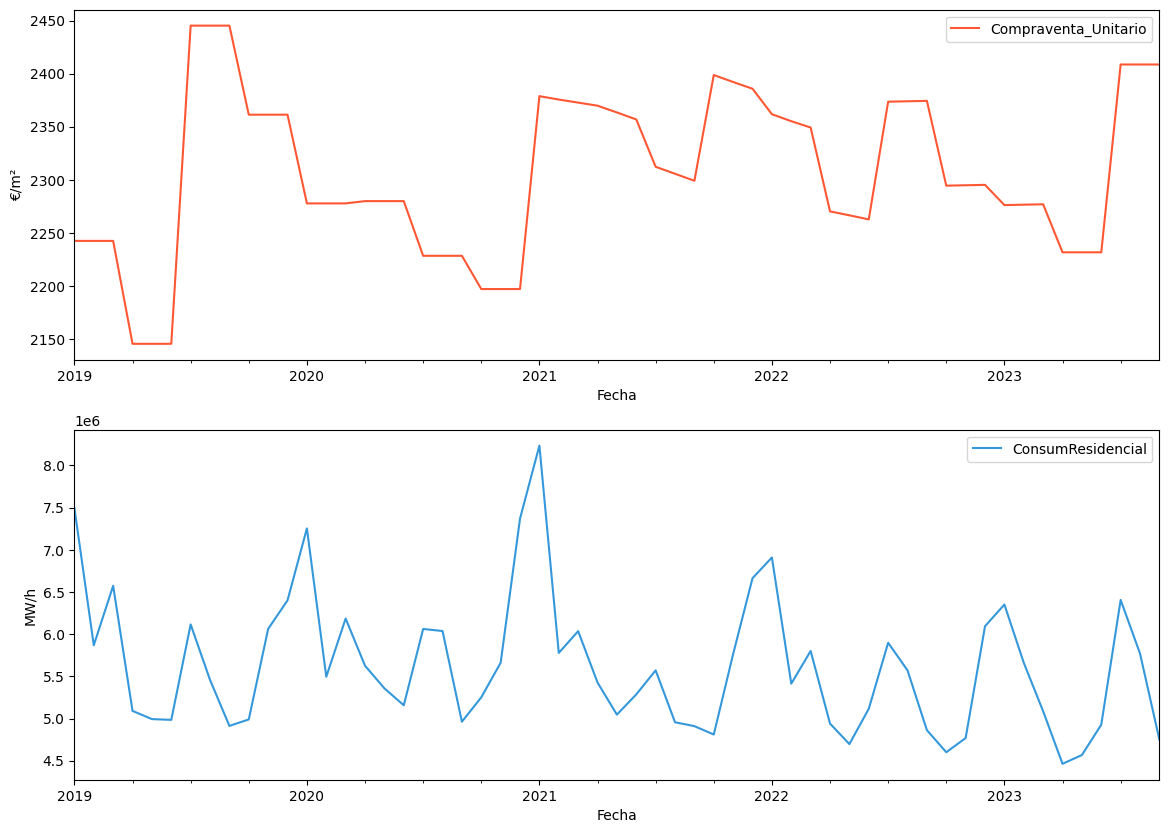

In [16]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', 'MW/h']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [17]:
corr=df.corr()
corr

,Compraventa_Unitario,ConsumResidencial
Compraventa_Unitario,1.000000,0.114702
ConsumResidencial,0.114702,1.000000


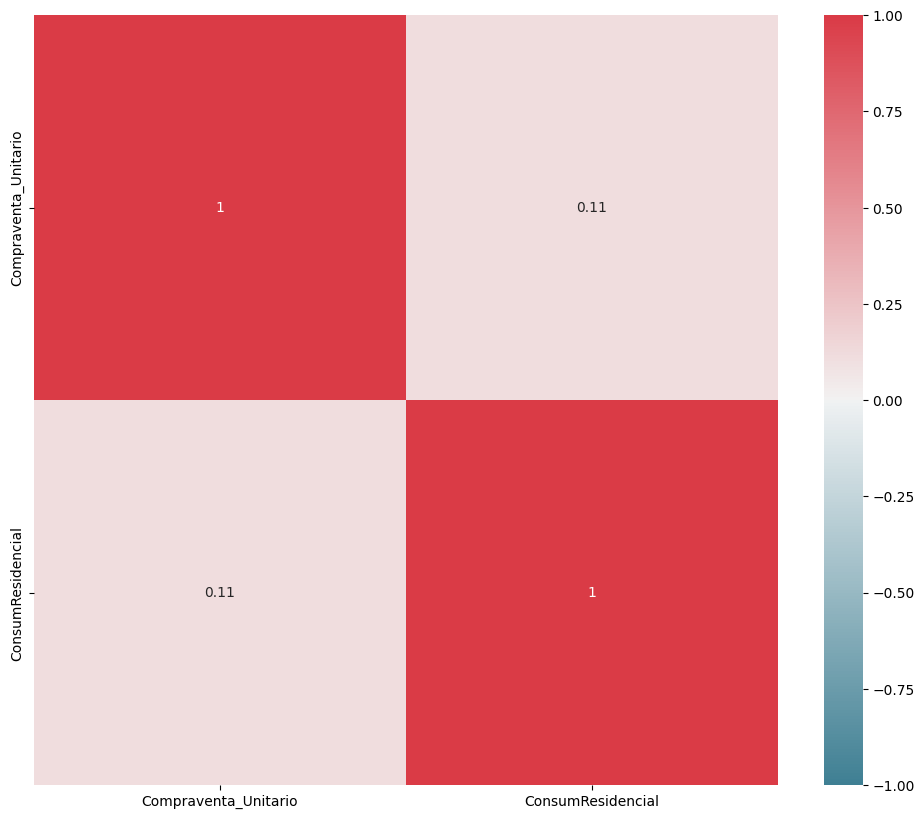

In [18]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "ConsumResidencial" es de 0.114702, lo que sugiere una correlación positiva moderada entre estas dos variables en tu modelo.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola serie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de sus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [19]:
fecha_division = '2023-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(48, 2) (9, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.031655
Serie de tiempo ConsumResidencial
p-value: 0.000061


Los p-valores son menores que 0.05, con lo cual se rechaza la hipótesis nula de que la serie no es estacionaria, por lo que esta serie es estacionaria

In [22]:
from statsmodels.tsa.api import VAR

In [23]:
model = VAR(X_train)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [46]:
modelsel=model.select_order(12)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,35.51,35.60,2.636e+15,35.54
1,34.73,34.99*,1.209e+15*,34.82*
2,34.88,35.32,1.413e+15,35.03
3,34.99,35.61,1.593e+15,35.21
4,35.21,36.00,2.001e+15,35.49
5,35.41,36.38,2.482e+15,35.75
6,35.60,36.74,3.090e+15,36.00
7,35.45,36.77,2.783e+15,35.92
8,35.64,37.13,3.528e+15,36.16
9,35.54,37.21,3.442e+15,36.12


Para seleccionar el orden adecuado en un modelo VAR (Vector Autoregression), generalmente se busca minimizar los criterios de información como el AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), FPE (Final Prediction Error) y HQIC (Hannan-Quinn Information Criterion). En nuestos datos el orden óptimo parece ser el modelo VAR(1), ya que tiene los valores más bajos en los criterios AIC, BIC y FPE, y uno de los valores más bajos en HQIC.


#### Ajustando el modelo

In [47]:
res = model.fit(maxlags=1, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     10:14:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    35.4046
Nobs:                     47.0000    HQIC:                   35.2573
Log likelihood:          -953.838    FPE:                1.87760e+15
AIC:                      35.1684    Det(Omega_mle):     1.65905e+15
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                         762.482964       259.686711            2.936           0.003
L1.Compraventa_Unitario         0.666161         0.111060            5.998           0.000
L1.Co

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "ConsumResidencial" es de -0.675291, lo que sugiere una correlación negativa alta entre los residuos de estas dos variables en tu modelo.

In [48]:
X_train.columns

Index(['Compraventa_Unitario', 'ConsumResidencial'], dtype='object')

###### Causalidad de Granger

In [49]:
grangercaus=res.test_causality(['ConsumResidencial'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.189,3.949,0.279,"(1, 88)"


In [50]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['ConsumResidencial'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.02055,3.949,0.886,"(1, 88)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [51]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=15
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train, variables = X_train.columns)

,Compraventa_Unitario_x,ConsumResidencial_x
Compraventa_Unitario_y,1.0,0.0
ConsumResidencial_y,0.0,1.0


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [52]:
residuals=res.resid

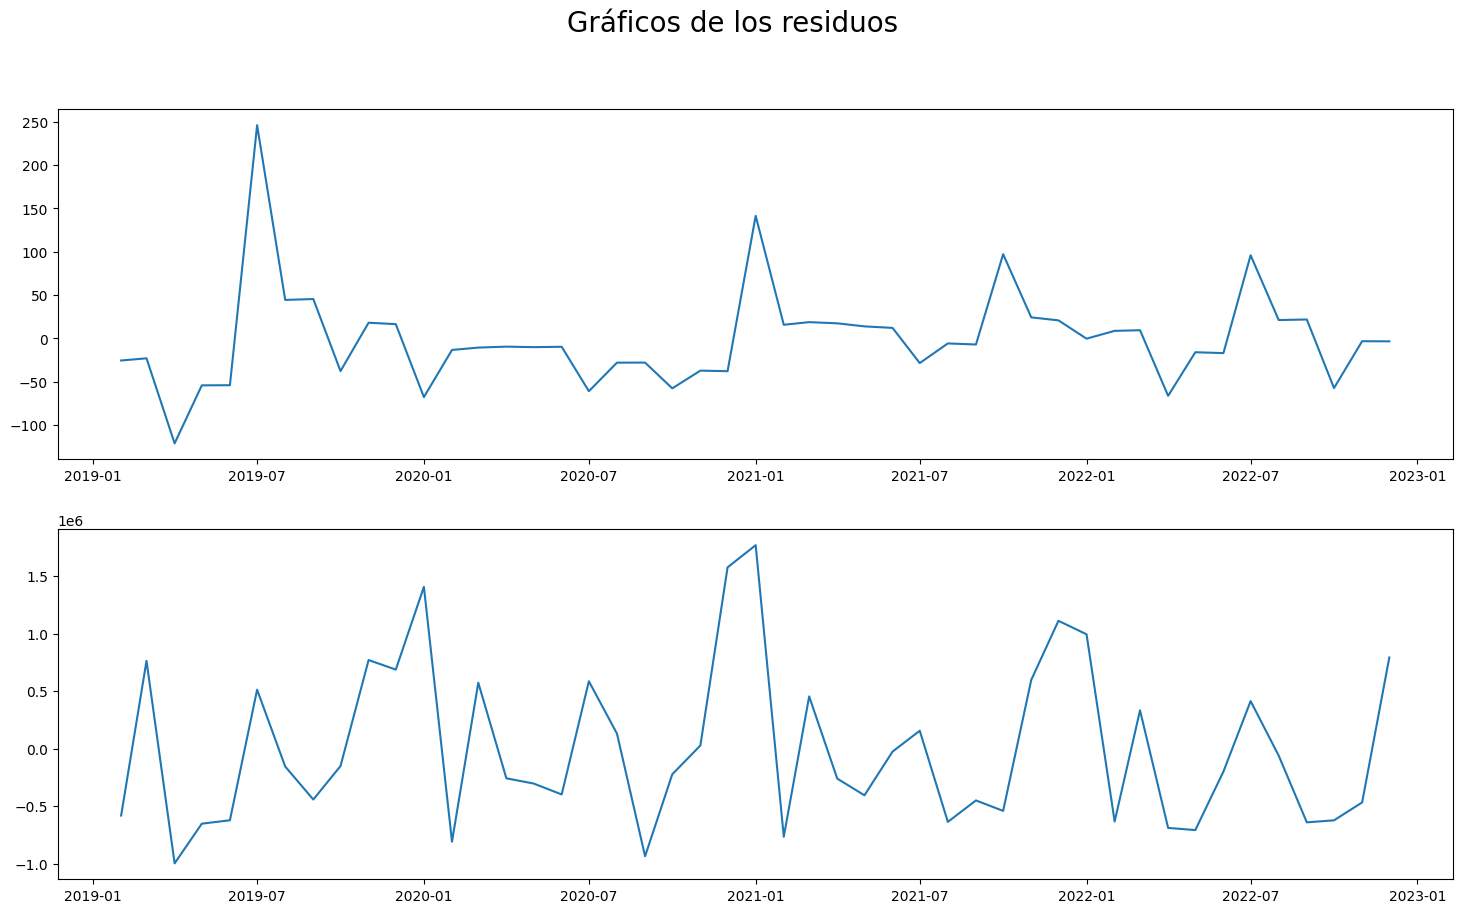

In [53]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [54]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[3.323964589954212e-07, 2.0283073703278502e-07]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


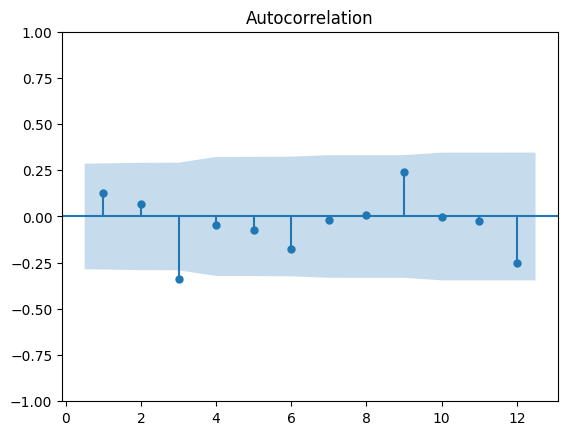

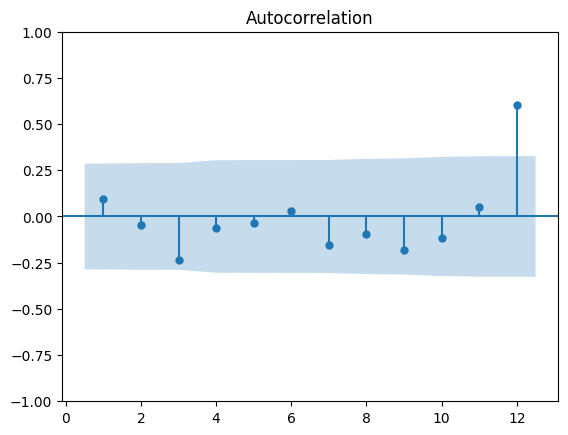

In [55]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


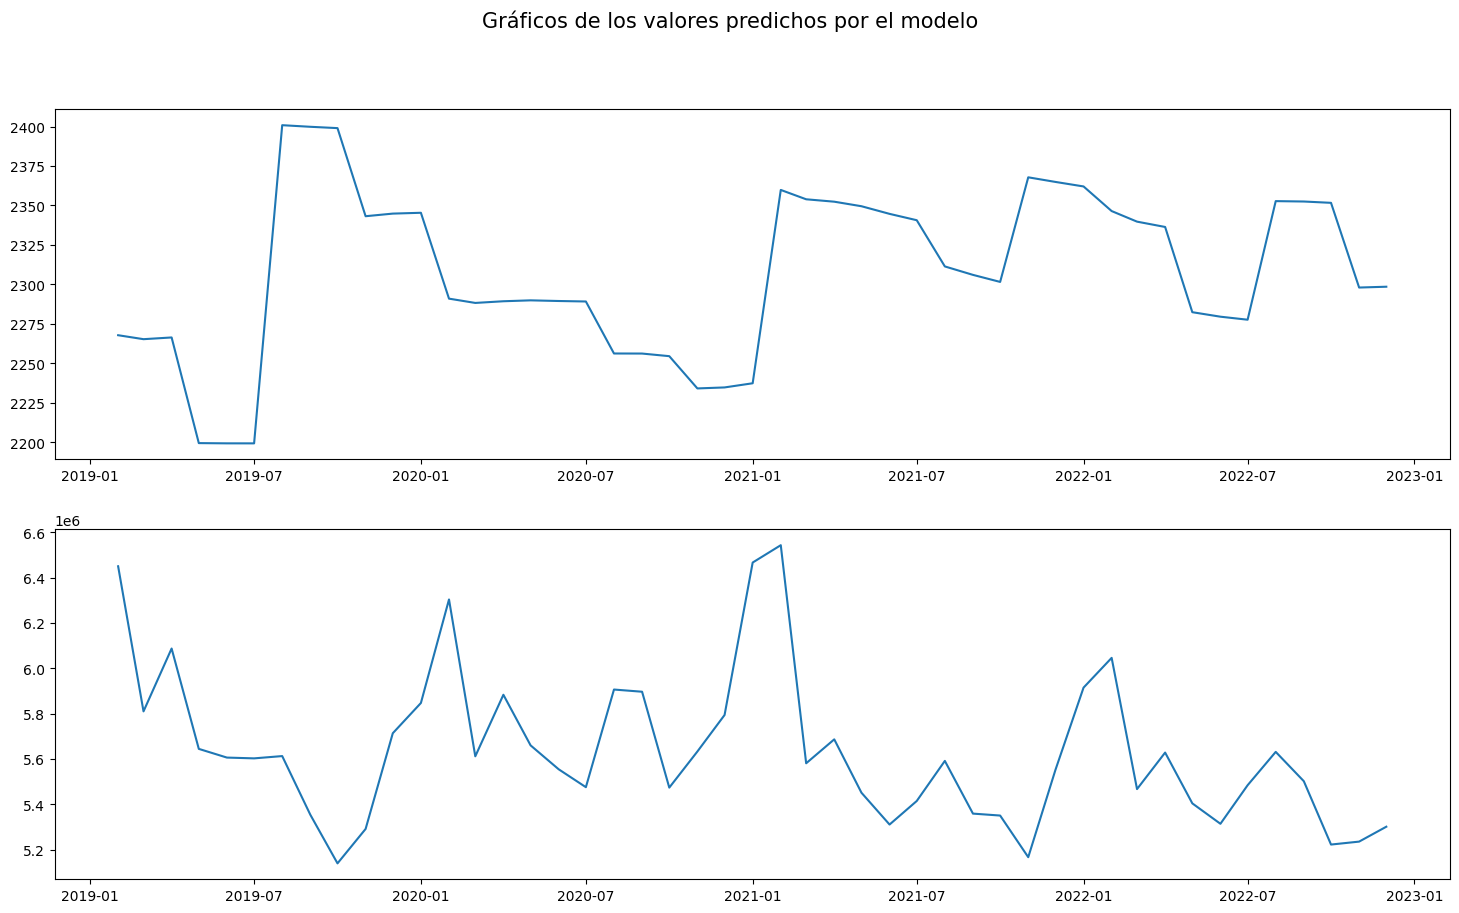

In [56]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [57]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=9)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns))
print('Predicciones:')
pred

Orden del modelo: 1
Predicciones:


,Compraventa_Unitario,ConsumResidencial
Fecha,,
2023-01-01,2300.875179,5.822653e+06
2023-02-01,2304.221947,5.707768e+06
2023-03-01,2306.274147,5.657735e+06
2023-04-01,2307.564034,5.635083e+06
2023-05-01,2308.388350,5.624304e+06
2023-06-01,2308.920844,5.618869e+06
2023-07-01,2309.267184,5.615960e+06
2023-08-01,2309.493413,5.614313e+06
2023-09-01,2309.641577,5.613338e+06


<Figure size 1200x1000 with 0 Axes>

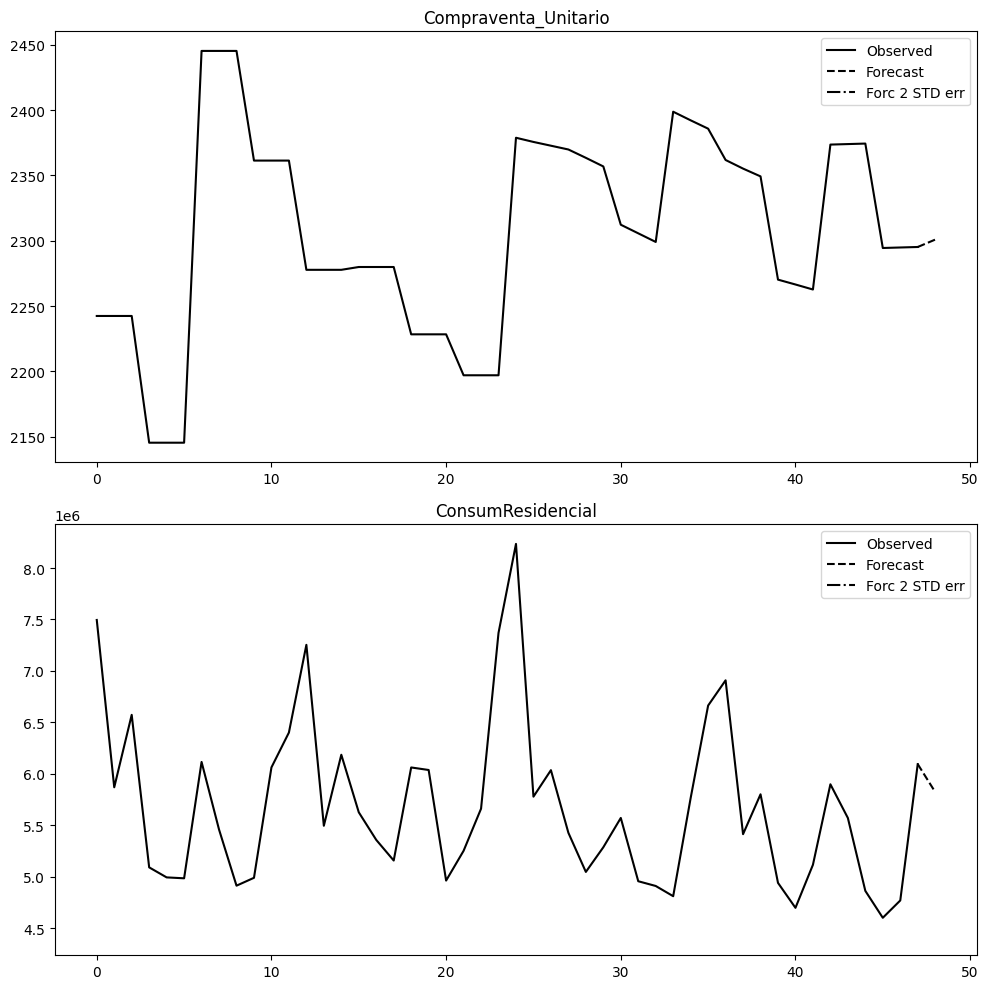

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


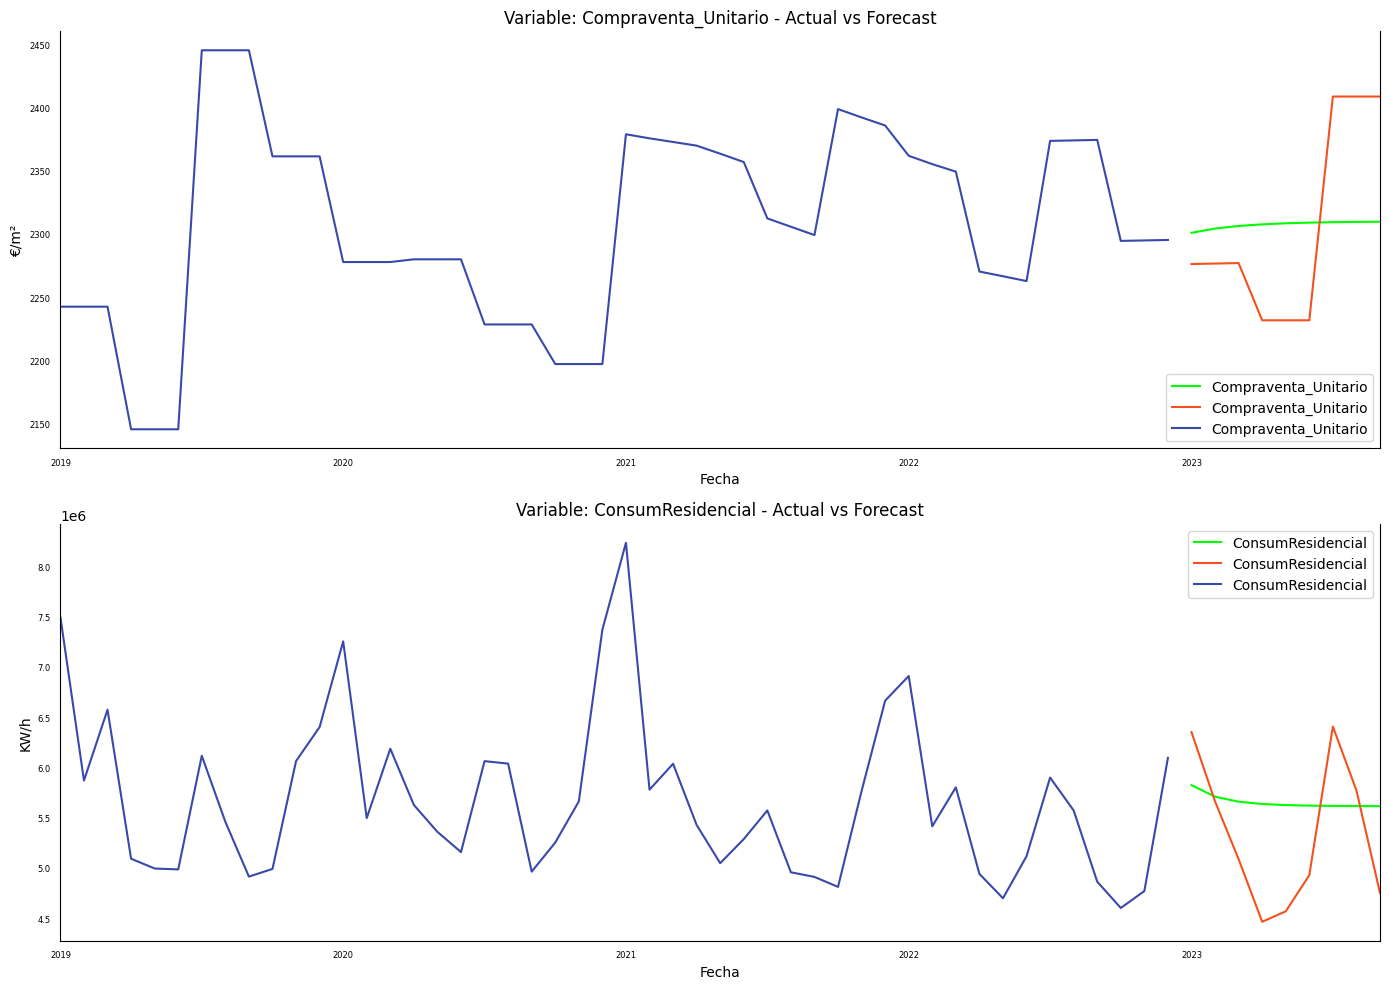

In [59]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'KW/h']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    pred[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [60]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [61]:
for i in ['Compraventa_Unitario', 'ConsumResidencial']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , pred[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 5481.657105363951
MAE is : 67.66292276030127
RMSE is : 74.03821381802744
MAPE is : 2.915098929334585
R2 is : 0.028059949783953098

Evaluation metric for ConsumResidencial
Evaluation metric results:-
MSE is : 552444432572.9077
MAE is : 653035.1110418058
RMSE is : 743266.0577296044
MAPE is : 13.006346810105537
R2 is : -0.13154535138061574





Los resultados de la evaluación muestran un rendimiento moderado para la variable "Compraventa_Unitario" con errores aceptables en las predicciones. Sin embargo, para "ConsumResidencial", se observa un rendimiento deficiente con errores significativamente altos y un coeficiente de determinación negativo, lo que indica que el modelo no es adecuado para explicar la variabilidad de los datos. Se sugiere una revisión exhaustiva del modelo y posiblemente la incorporación de más variables explicativas para mejorar la precisión de las predicciones.

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, pred)))

Mean absolute error: 460524.5216783157
Root mean squared error: 865669.6328031572


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [62]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.3 MB/s eta 0:00:00


#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [63]:
fecha_division = '2023-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(48, 2) (9, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [64]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.031655
Serie de tiempo ConsumResidencial
p-value: 0.000061


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [65]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [66]:
cointegration_test(X_train[['Compraventa_Unitario','ConsumResidencial']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  9.14      > 12.3212   =>   False
ConsumResidencial >  0.07      > 4.1296    =>   False


Para la variable "Compraventa_Unitario", el valor estadístico del test es 9.14, y el valor crítico en el nivel de confianza del 95% es 12.3212. Como el valor estadístico es menor que el valor crítico, no hay suficiente evidencia para rechazar la hipótesis nula de no cointegración. Por lo tanto, se concluye que no hay evidencia de cointegración para esta variable.

Para la variable "ConsumResidencial", el valor estadístico del test es 0.07, y el valor crítico en el nivel de confianza del 95% es 4.1296. Al igual que en el caso anterior, como el valor estadístico es menor que el valor crítico, no hay suficiente evidencia para rechazar la hipótesis nula de no cointegración. Por lo tanto, se concluye que no hay evidencia de cointegración para esta variable.

Si las variables en un modelo VARMAX no están cointegradas, significa que no comparten una relación a largo plazo y pueden tener comportamientos divergentes en el tiempo. Esto puede tener varias repercusiones para el modelo VARMAX:

- Modelado inadecuado de las relaciones a largo plazo

- Menor capacidad predictiva

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [67]:
import pmdarima as pm

In [68]:

pq = []
for name in ['Compraventa_Unitario', 'ConsumResidencial']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=881.650, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=547.410, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.91 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=549.408, Time=0.61 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=547.892, Time=1.34 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=532.714, Time=0.43 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=539.843, Time=0.69 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=531.580, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=557.819, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=531.815, Time=1.18 sec
 ARIMA(2,0,1)

#####Seleccion del modelo

In [69]:
pq

[(1, 0, 0), (0, 0, 2)]

Para la serie temporal de compraventa unitario

- *p=1:* Indica que se incluye un término autoregresivo de primer orden para esta variable en el modelo, es decir, se considera la dependencia de la variable respecto a su propio valor en el periodo anterior.

- *q=0:* Indica que no se incluyen términos de medias móviles para esta variable en el modelo, lo que significa que no se considera la dependencia de los errores pasados de esta variable en sí misma.

Para la serie temporal de consumo electrico residencial

- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMAX no incluye dependencia de los valores pasados de las variables en sí mismas.

- *q=0: *Indica que no se incluyen términos de medias móviles para esta variable en el modelo, lo que significa que no se considera la dependencia de los errores pasados de esta variable en sí misma.

In [70]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [71]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)]
    return df_res

In [72]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Compraventa_Unitario','RMSE ConsumResidencial'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(X_train[['Compraventa_Unitario', 'ConsumResidencial']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 9)
        inv_res =  inv_res = inverse_diff(df[['Compraventa_Unitario',  'ConsumResidencial']],result)
        Comprarmse = np.sqrt(metrics.mean_squared_error(X_test['Compraventa_Unitario'], inv_res.Compraventa_Unitario))
        Pmrmse = np.sqrt(metrics.mean_squared_error(X_test['ConsumResidencial'], inv_res.ConsumResidencial))

        #df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Compraventa_Unitario':Comprarmse,'RMSE ParadosReg':Paradosrmse }, ignore_index=False)
        df_results_moni.loc[len(df_results_moni)] = [i[0], i[2], Comprarmse, Pmrmse]


Grid Search Started
 Running for (1, 0, 0)
 Running for (0, 0, 2)


In [73]:
df_results_moni.sort_values(by = ['RMSE Compraventa_Unitario','RMSE ConsumResidencial'] )

,p,q,RMSE Compraventa_Unitario,RMSE ConsumResidencial
0,1.0,0.0,2403.350889,5.204245e+06
1,0.0,2.0,2411.323447,5.159518e+06


#### Pronósticos a futuro


In [75]:
model = VARMAX(X_train[['Compraventa_Unitario','ConsumResidencial']], order=(1,0),trend='c').fit(disp=False)
result = model.forecast(steps = 9)

In [76]:
result

,Compraventa_Unitario,ConsumResidencial
2023-01-01,2296.998407,5.881965e+06
2023-02-01,2298.117502,5.786802e+06
2023-03-01,2298.835052,5.743580e+06
2023-04-01,2299.300805,5.723625e+06
2023-05-01,2299.605699,5.714202e+06
2023-06-01,2299.806449,5.709621e+06
2023-07-01,2299.939146,5.707312e+06
2023-08-01,2300.027089,5.706099e+06
2023-09-01,2300.085472,5.705434e+06


#### Invertiendo la transformacion de los pronosticos a la escala original

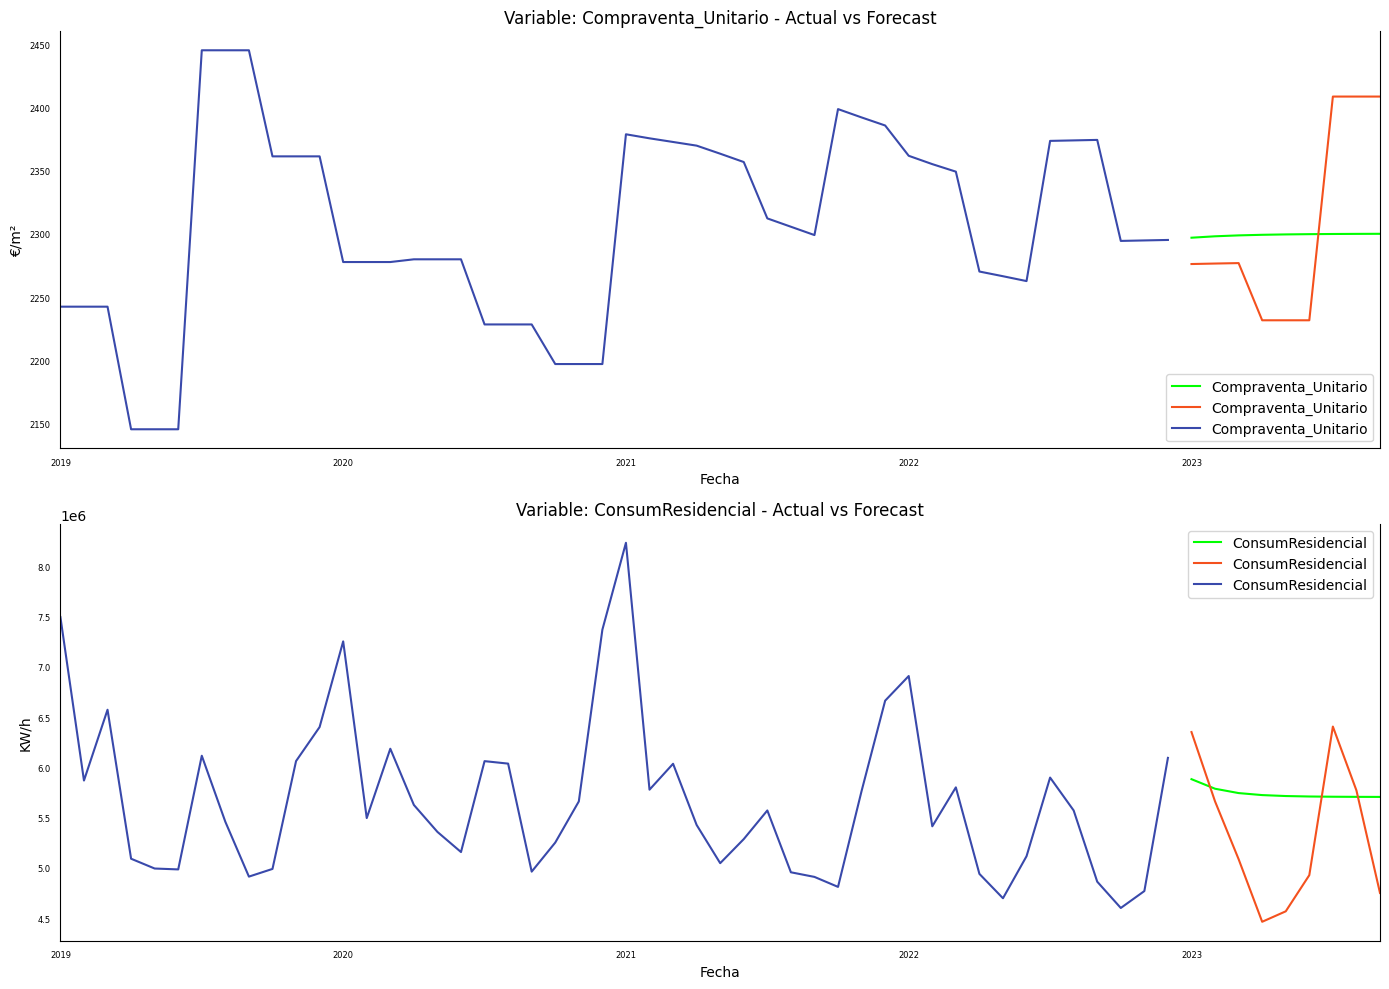

In [77]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'KW/h']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    result[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [78]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [79]:
for i in ['Compraventa_Unitario','ConsumResidencial']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , result[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 5620.712707409015
MAE is : 65.97068726662185
RMSE is : 74.97141260113094
MAPE is : 2.8306149743370113
R2 is : 0.0034043198828688226

Evaluation metric for ConsumResidencial
Evaluation metric results:-
MSE is : 621229849929.8195
MAE is : 684559.2040142269
RMSE is : 788181.3559897363
MAPE is : 13.769298613281256
R2 is : -0.2724352122676055



Basado en las métricas de evaluación, para "Compraventa_Unitario" el modelo parece tener un desempeño moderado con un error cuadrático medio (MSE) de 5620.71 y un coeficiente de determinación (R2) cercano a cero, lo que indica que el modelo no explica bien la variabilidad de los datos. En cuanto a "ConsumResidencial", el modelo presenta un desempeño deficiente con un MSE muy alto de 621229849929.82 y un R2 negativo, lo que sugiere que el modelo no se ajusta bien a los datos y puede estar sobreajustado.

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, result))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, result)))

Mean absolute error: 342312.5873507468
Root mean squared error: 557328.3841464259


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_Unitario y consumo electrico residencial tenemos que:

- Se ha comprobado que las variables apenas tienen correlacion.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad, lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido negativa, lo que quiere decir que ninguna serie temporal puede predecir las demas series temporales. Esto en un principio nos advierte que este modelo sera más aconsejable que el modelo VARMAX
- El test de cointegracion en el modelo VARMAX nos ha dado negativo, lo que significa que las series no estan relacionadas en el tiempo y que serie mas acosnsejable un modelo VAR.

Ambos modelos no obtienen buenos resultados. El hecho de que la serie temporal sea relativamente corta, puede tener bastante que ver.

